In [1]:
from functools import partial
from matplotlib.legend_handler import HandlerLine2D


from pathlib import Path
location = 'ca'

path = Path(location)

from joblib import Memory
memory = Memory(path, verbose=1)

from routines import classic_game, comparing_planning_game, comparing_receding_game 
import numpy as np 
from scipy.optimize import *

import matplotlib.pyplot as plt
import seaborn as sns

from parameters import *
from models.game_theory_model import *
from models.game import *
from utility.array_to_latex import array_to_latex
from itertools import product


from matplotlib import ticker
M=4

from ipywidgets import interact

from plot_param import *
from utility.plot_functions import *

temperature_target = None
final_multiplier = 0

case = 'sigmoid'

horizon = 2100

# PARAM

In [2]:
horizon = 2100

X = 2025 + np.arange((horizon-2020)//5  )*5


##### title

title_temperature = f'Temperature Trajectories under Various Solutions ({FIRST_YEAR}-{FINAL_YEAR})'
title_emission = f'CO2 Emission Trajectories under Various Solutions ({FIRST_YEAR}-{FINAL_YEAR})'

##### x-label

x_label_time = f'Years ({FIRST_YEAR}-{FINAL_YEAR})'


##### y-label

y_label_temperature = 'Projected Temperature Variation (°C)'
y_label_emission = 'Annual Global CO2 Emissions (Gt)'
y_label_utility = r"Player's Utility"
y_label_individual_emission = 'Annual Individual CO2 Emissions (Gt)'

In [6]:
r = [1.15, 1.60, 2, 0.5, 1.25,0.75]
e = [2, -2, -5, -4, -5, 2.5]

# Action set doubled

r = [0.70, 1, 2, 0.5, 1.25,0.45]
e = [3, -1, -5, -4, -5, 2.5]

list_list_benefit_functions = [
                                [partial(benefit_sigm, e=e[i], r = r[i]) for i in range(N)],
                                # BENEFITS_CONCAVE,
                                ]
 #[partial(benefit_sigm, e=e[i], r = r[i]) for i in range(N)], BENEFITS_LOG]
list_label_benefit_function = [
                                ('Sigmoid', '-'),
                                # ('Concave', '--'),
                                ]



list_damage_coef_classic = [ np.array([0,0,1]) ,np.array([0,0.25,0.16])]# , np.array([0,-2,2])] #, np.array([0,0,2]) ] #np.array([0,-2,2]),  np.array([0,-0.5,1.1])] #, np.array([0,0,1.1450]), np.array([0,0,0,0,1])]
list_alpha = [1,1.5, 2] #[1,1.5,2]

list_damage_function_classic = [
    partial(sigmoid, K=10, e0=2.5, r=3.5)
    ] + [
        # partial(damage_polynome, coefficients=coef) for coef in list_damage_coef_classic
    ] + [
    partial(damage_exponential, coefficients = np.array([1.5,0.7,-2.70])),
    ]

list_list_benefit_functions = [[partial(benefit_sigm, e=e[i], r = r[i]) for i in range(len(BENEFITS_SIGMOID))],
                            #    BENEFITS_LOG
                               ]
list_label_benefit_function = [
                        ('Sigmoid', '-'), 
                        # ('log', '-')
                        ]

list_damage_label_classic =  ['sigm'] + [
    # array_to_latex(coef) for coef in list_damage_coef_classic
] + [
    #'exp'
    ]



list_param_classic = list(product(list_damage_function_classic, list_alpha, list_list_benefit_functions))
list_label_classic = list(product(list_damage_label_classic, list_alpha, list_label_benefit_function))

In [7]:
def set_exp_coef(a, b, c):
    x = np.linspace(0,6)
    plt.plot(x, partial(damage_exponential, coefficients = np.array([a,b,c]))(x))

interact(set_exp_coef, a=(-1,4,0.01), b=(-10,10,0.01), c=(-10,10,0.01))

interactive(children=(FloatSlider(value=1.0, description='a', max=4.0, min=-1.0, step=0.01), FloatSlider(value…

<function __main__.set_exp_coef(a, b, c)>

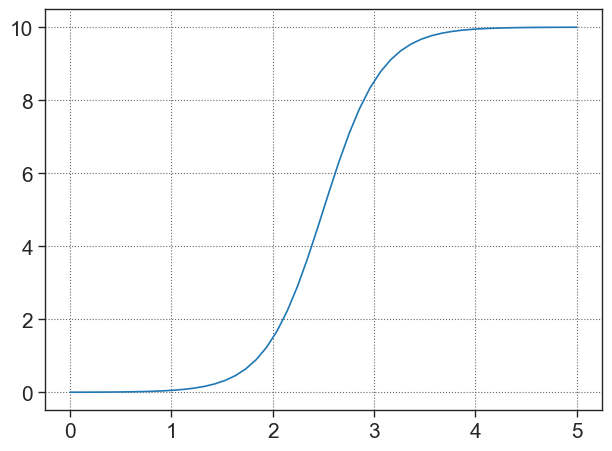

In [8]:
x = np.linspace(0,5)

plt.plot(x, list_damage_function_classic[0](x))

In [9]:
from matplotlib.legend_handler import HandlerTuple

def plots(classic, directory, list_label, case = '', title ='', X = X, SO = True) :

    (list_ne, list_so, list_ne_u, list_so_u, list_ne_planning_u, list_so_planning_u, 
            list_sum_action, list_sum_utilities, list_temp, list_sum_action_so, list_sum_utilities_so, list_temp_so, 
            list_sum_action_planning, list_sum_utilities_planning, list_temp_planning, list_sum_action_planning_so, 
            list_sum_utilities_planning_so, list_temp_planning_so, list_ne_planning, list_so_planning) = classic

    from pathlib import Path

    Path("{}/{}".format(directory,case)).mkdir(parents=True, exist_ok=True)
    directory = directory + '/' + case 

    
    def update_prop(handle, orig):
        handle.update_from(orig)
        handle.set_marker("")

    param_fig = {'figsize' : (12,7), 'dpi': 100}


    label_list = [r'$D = {},\, \alpha = {}$'.format(label[0], label[1]) for label in list_label]

    xlabel = x_label_time
    if SO : 
        plot_kwargs_list = [
            {**one_shot_style_curve, **ne_style},
            {**so_style_curve, **one_shot_style_curve},
            {**ne_style, **planning_style_curve},
            {**so_style_curve, **planning_style_curve}
        ]
        legend_handle =[
            Line2D([0], [0], color=f'C{idx}') for idx, lab in enumerate(label_list)
        ] + [(Line2D([0], [0], **one_shot_style, linestyle = 'None', color='black'), Line2D([0], [0], **one_shot_style, linestyle = 'None', c='black',markerfacecolor='white')),
            (Line2D([0], [0], **planning_style, linestyle = 'None', color='black'), Line2D([0], [0], **planning_style, linestyle = 'None', c='black', markerfacecolor='white')),
            ] 
    else : 
        plot_kwargs_list = [
            {**one_shot_style_curve, **ne_style},
            {**ne_style, **planning_style_curve},
        ]
        legend_handle =[
            Line2D([0], [0], color=f'C{idx}') for idx, lab in enumerate(label_list)
            ] + [Line2D([0], [0], **one_shot_style, linestyle = 'None', color='black'),
                Line2D([0], [0], **planning_style, linestyle = 'None', color='black')
                ] 
    # legend_handle =[
    #     Line2D([0], [0], color=f'C{idx}') for idx, lab in enumerate(label_list)
    # ] + [
    #                     (Line2D([0], [0], **one_shot_style, linestyle = 'None', color='black'), Line2D([0], [0], **one_shot_style, linestyle = 'None', c='black',markerfacecolor='white')),
    #                     (Line2D([0], [0], **planning_style, linestyle = 'None', color='black'), Line2D([0], [0], **planning_style, linestyle = 'None', c='black', markerfacecolor='white')),
    # ] 

    legend_label = label_list + ['One-shot', 'Planning']
    param_legend = {'handles' : legend_handle, 'labels' : legend_label, 'ncol': 2, 'fancybox' : True, 'framealpha' : 0.5, 'handler_map' : {tuple: HandlerTuple(ndivide=None)}}
    # [r'${}, {}, \alpha = {}$'.format(label[2][0], label[0], label[1]) for label in list_label]

    if SO :
        array_list = [list_sum_action, list_sum_action_so, list_sum_action_planning, list_sum_action_planning_so]
    else :
        array_list = [list_sum_action, list_sum_action_planning]

    title = title_emission
    ylabel = y_label_emission
    save_file = directory + "/Annual_Global_CO2_Emission_planning_{}_{}".format(case, horizon)
    multi_parallel_plot(array_list=array_list,
                        X=X, 
                        plot_kwargs_list=plot_kwargs_list, 
                        title=title, 
                        xlabel=xlabel, 
                        ylabel=ylabel, 
                        save_file=save_file, 
                        param_fig=param_fig, 
                        param_legend=param_legend,
                        step = True
                        )
    if SO :
        array_list = [list_sum_utilities, list_sum_utilities_so, list_sum_utilities_planning, list_sum_utilities_planning_so]
    else :
        array_list = [list_sum_utilities, list_sum_utilities_planning]

    title = r'Global GDP $\bar{u}_t$ evolution in time'
    ylabel = r'Annual World Utility $\bar{u}_t$ in  $10^{10}$\$ 2011'
    save_file = directory + "/Annual_World_Utility_planning_{}_{}".format(case, horizon)

    multi_parallel_plot(array_list=array_list,
                        X=X, 
                        plot_kwargs_list=plot_kwargs_list, 
                        title=title, 
                        xlabel=xlabel, 
                        ylabel=ylabel, 
                        save_file=save_file, 
                        param_fig=param_fig, 
                        param_legend=param_legend,
                        step = False
                        )
    if SO :
        array_list = [list_temp, list_temp_so, list_temp_planning, list_temp_planning_so]
    else :
        array_list = [list_temp, list_temp_planning]
    title = title_temperature
    ylabel = y_label_temperature
    save_file = directory + "/Global_Mean_Temperature_planning_{}_{}".format(case, horizon)

    multi_parallel_plot(array_list=array_list,
                        X=X, 
                        plot_kwargs_list=plot_kwargs_list, 
                        title=None, 
                        xlabel=xlabel, 
                        ylabel=ylabel, 
                        save_file=save_file, 
                        param_fig=param_fig, 
                        param_legend=param_legend,
                        step = False
                        )
    n_row = 3
    n_col = 2

    plt.rcParams["figure.autolayout"] = True

    if SO : 
        plot_kwargs_list = [
            {**one_shot_style, **ne_style},
            {**so_style_curve, **one_shot_style_curve},
            {**ne_style, **planning_style_curve},
            {**so_style_curve, **planning_style_curve}
        ]
    else :
        plot_kwargs_list = [
            {**one_shot_style, **ne_style},
            {**ne_style, **planning_style_curve},
        ]

    for arg in plot_kwargs_list:
        arg['markevery'] = (0,5)
        arg['ms'] = 8
    temp0, temp1 = figsize
    tfigsize = (temp1, temp0)

    fig, axes = plt.subplots(n_row, n_col, dpi = 100, figsize=(temp1, temp0))
    k = 0
    for row in range(n_row):
        for col in range(n_col):
            if SO : 
                array_list = [[ne_u[k] for ne_u in list_ne_u], [so_u[k] for so_u in list_so_u], [ne_planning_u[k] for ne_planning_u in list_ne_planning_u], [so_planning_u[k] for so_planning_u in list_so_planning_u]]
            else :
                array_list = [[ne_u[k] for ne_u in list_ne_u], [ne_planning_u[k] for ne_planning_u in list_ne_planning_u]]

            title = NAMES[k]
            axes[row, col] = multi_parallel_plot(ax = axes[row,col], X = X, array_list=array_list, plot_kwargs_list=plot_kwargs_list, title=title, param_fig=param_fig)
            xticks = ticker.MaxNLocator(M)
            axes[row, col].xaxis.set_major_locator(xticks)
            k += 1
    fig.supylabel(y_label_utility)
    fig.supxlabel(xlabel)
    save_file =  directory + "/Utilities_planning_{}_{}.pdf".format(case, horizon)

    plt.savefig(fname= save_file, format='pdf')
    plt.show()

    fig, axes = plt.subplots(n_row, n_col, dpi = 100, figsize=tfigsize)
    k = 0
    for row in range(n_row):
        for col in range(n_col):
            if SO : 
                array_list = [[ne[k] for ne in list_ne], [a[k] for a in list_so], [a[k] for a in list_ne_planning], [a[k] for a in list_so_planning]]
            else :
                array_list = [[ne[k] for ne in list_ne], [a[k] for a in list_ne_planning]]

            title = NAMES[k]
            axes[row, col] = multi_parallel_plot(step = True, 
                                                 ax = axes[row,col], X = X, array_list=array_list, plot_kwargs_list=plot_kwargs_list, title=title, param_fig=param_fig)
            xticks = ticker.MaxNLocator(M)
            axes[row, col].xaxis.set_major_locator(xticks)
            k +=1
    fig.supylabel(y_label_individual_emission)
    fig.supxlabel(xlabel)
    save_file =  directory + "/Actions_planning_{}_{}.pdf".format(case, horizon)

    plt.savefig(fname= save_file, format='pdf')
    plt.show()

    plt.rcParams["figure.autolayout"] = False


    fig = plt.figure(constrained_layout=True, figsize=figsize, dpi=300)

    subfigs = fig.subfigures(1,2)    
    
    subfig = subfigs[0]
    axs = subfig.subplots(n_row, n_col)
    for idx, ax in enumerate(axs.flat) : 
        if SO : 
            array_list = [[ne_u[idx] for ne_u in list_ne_u], [so_u[idx] for so_u in list_so_u], [ne_planning_u[idx] for ne_planning_u in list_ne_planning_u], [so_planning_u[idx] for so_planning_u in list_so_planning_u]]
        else :
            array_list = [[ne_u[idx] for ne_u in list_ne_u], [ne_planning_u[idx] for ne_planning_u in list_ne_planning_u]]        
        title = NAMES[idx]
        ax = multi_parallel_plot(ax = ax, X = X, array_list=array_list, plot_kwargs_list=plot_kwargs_list, title=title, param_fig=param_fig)
        xticks = ticker.MaxNLocator(M)
        ax.xaxis.set_major_locator(xticks)
    subfig.supylabel(y_label_utility, fontsize='x-large')
    subfig.supxlabel(xlabel, fontsize='x-large')
 

    subfig = subfigs[1]
    axs = subfig.subplots(n_row, n_col)
    for idx, ax in enumerate(axs.flat) : 
        if SO : 
            array_list = [[ne[idx] for ne in list_ne], [a[idx] for a in list_so], [a[idx] for a in list_ne_planning], [a[idx] for a in list_so_planning]]
        else :
            array_list = [[ne[idx] for ne in list_ne], [a[idx] for a in list_ne_planning]]
        title = NAMES[idx]
        ax = multi_parallel_plot(step = True, ax = ax, X = X, array_list=array_list, plot_kwargs_list=plot_kwargs_list, title=title, param_fig=param_fig)
        xticks = ticker.MaxNLocator(M)
        ax.xaxis.set_major_locator(xticks)

    subfig.supylabel(y_label_individual_emission)
    subfig.supxlabel(xlabel, fontsize='x-large')
    save_file =  directory + "/test_{}_{}.pdf".format(case, horizon)

    plt.savefig(fname= save_file, format='pdf')
    plt.show()


In [10]:
classic = classic_game(list_param_classic, list_label_classic, horizon=horizon)

________________________________________________________________________________
[Memory] Calling routines.classic_game...
classic_game([ ( functools.partial(<function sigmoid at 0x0000021FE262ACA0>, K=10, e0=2.5, r=3.5),
    1,
    [ functools.partial(<function benefit_sigm at 0x0000021FE262AD30>, e=3, r=0.7),
      functools.partial(<function benefit_sigm at 0x0000021FE262AD30>, e=-1, r=1),
      functools.partial(<function benefit_sigm at 0x0000021FE262AD30>, e=-5, r=2),
      functools.partial(<function benefit_sigm at 0x0000021FE262AD30>, e=-4, r=0.5),
      functools.partial(<function benefit_sigm at 0x0000021FE262AD30>, e=-5, r=1.25),
      functools.partial(<function benefit_sigm at 0x0000021FE262AD30>, e=2.5, r=0.45)]),
  ( functools.partial(<function sigmoid at 0x0000021FE262ACA0>, K=10, e0=2.5, r=3.5),
    1.5,
  ..., 
[ ('sigm', 1, ('Sigmoid', '-')),
  ('sigm', 1.5, ('Sigmoid', '-')),
  ('sigm', 2, ('Sigmoid', '-'))], horizon=2100)
Running f(%s)
coef: sigm alpha: 1 function

Repeated One-shot BRD:   0%|          | 0/16 [00:00<?, ?it/s]

Repeated One-shot SO: 100%|██████████| 16/16 [00:00<00:00, 36.59it/s]


-----------------------------------------------------------
coef: sigm alpha: 1.5 function: Sigmoid


Repeated One-shot SO: 100%|██████████| 16/16 [00:00<00:00, 57.34it/s]


-----------------------------------------------------------
coef: sigm alpha: 2 function: Sigmoid


Repeated One-shot SO: 100%|██████████| 16/16 [00:00<00:00, 75.08it/s]


-----------------------------------------------------------
_____________________________________________________classic_game - 7.6s, 0.1min


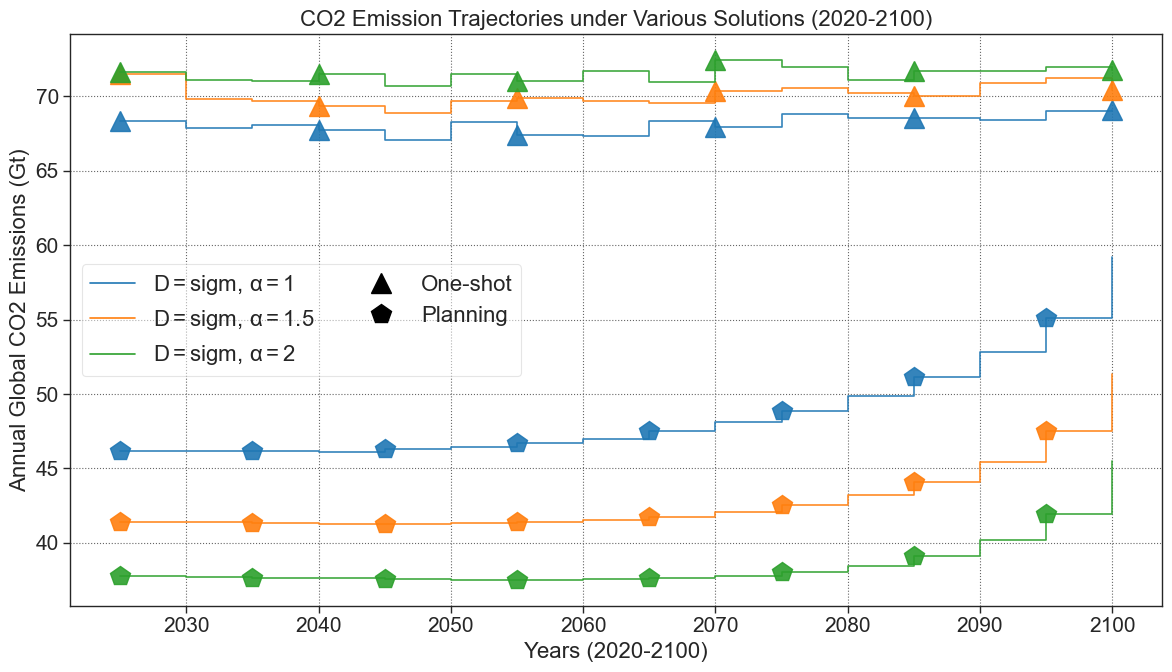

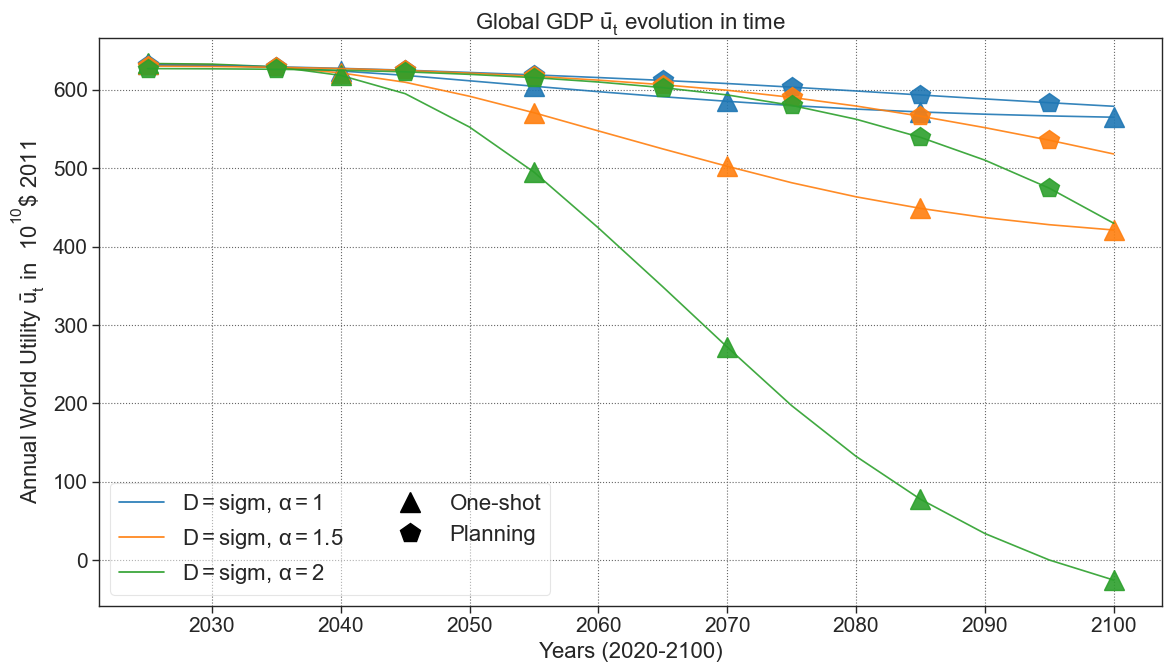

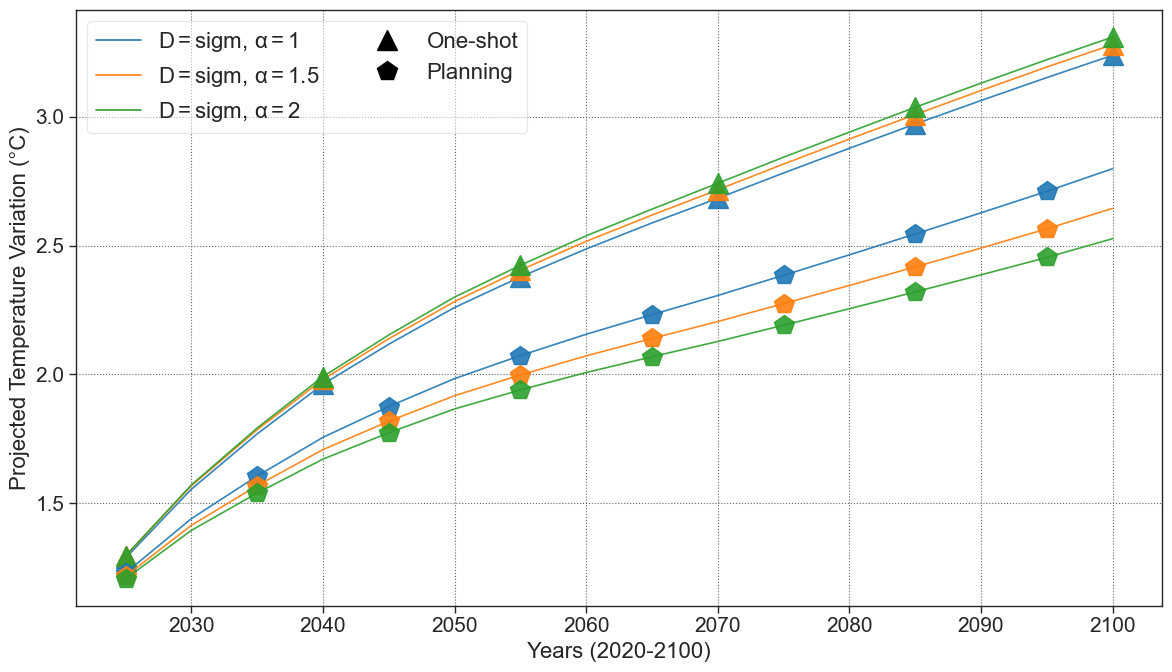

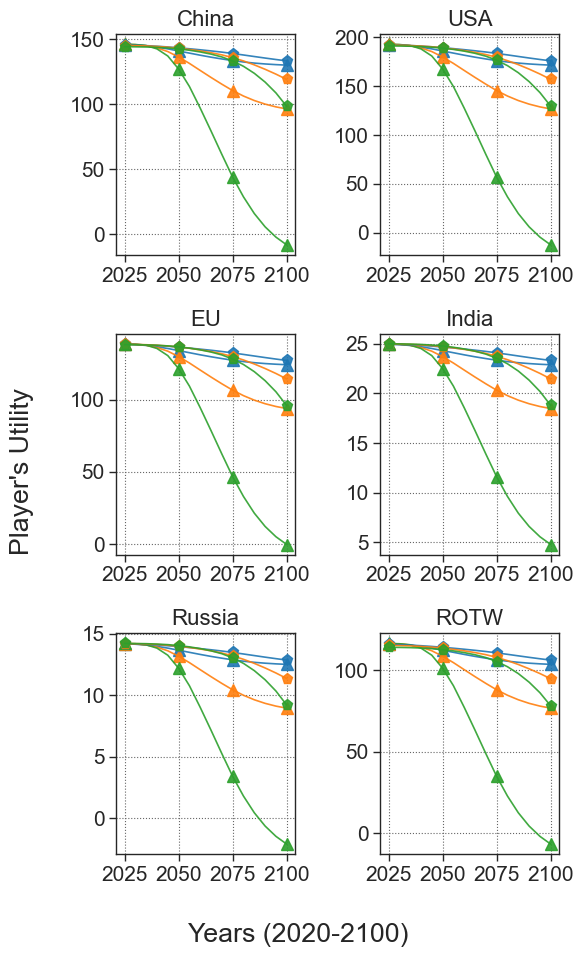

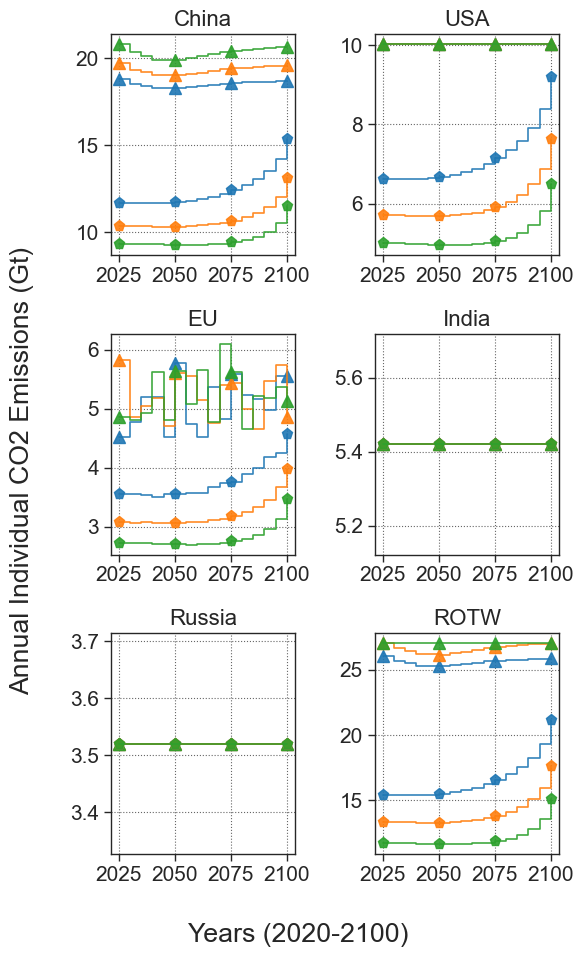

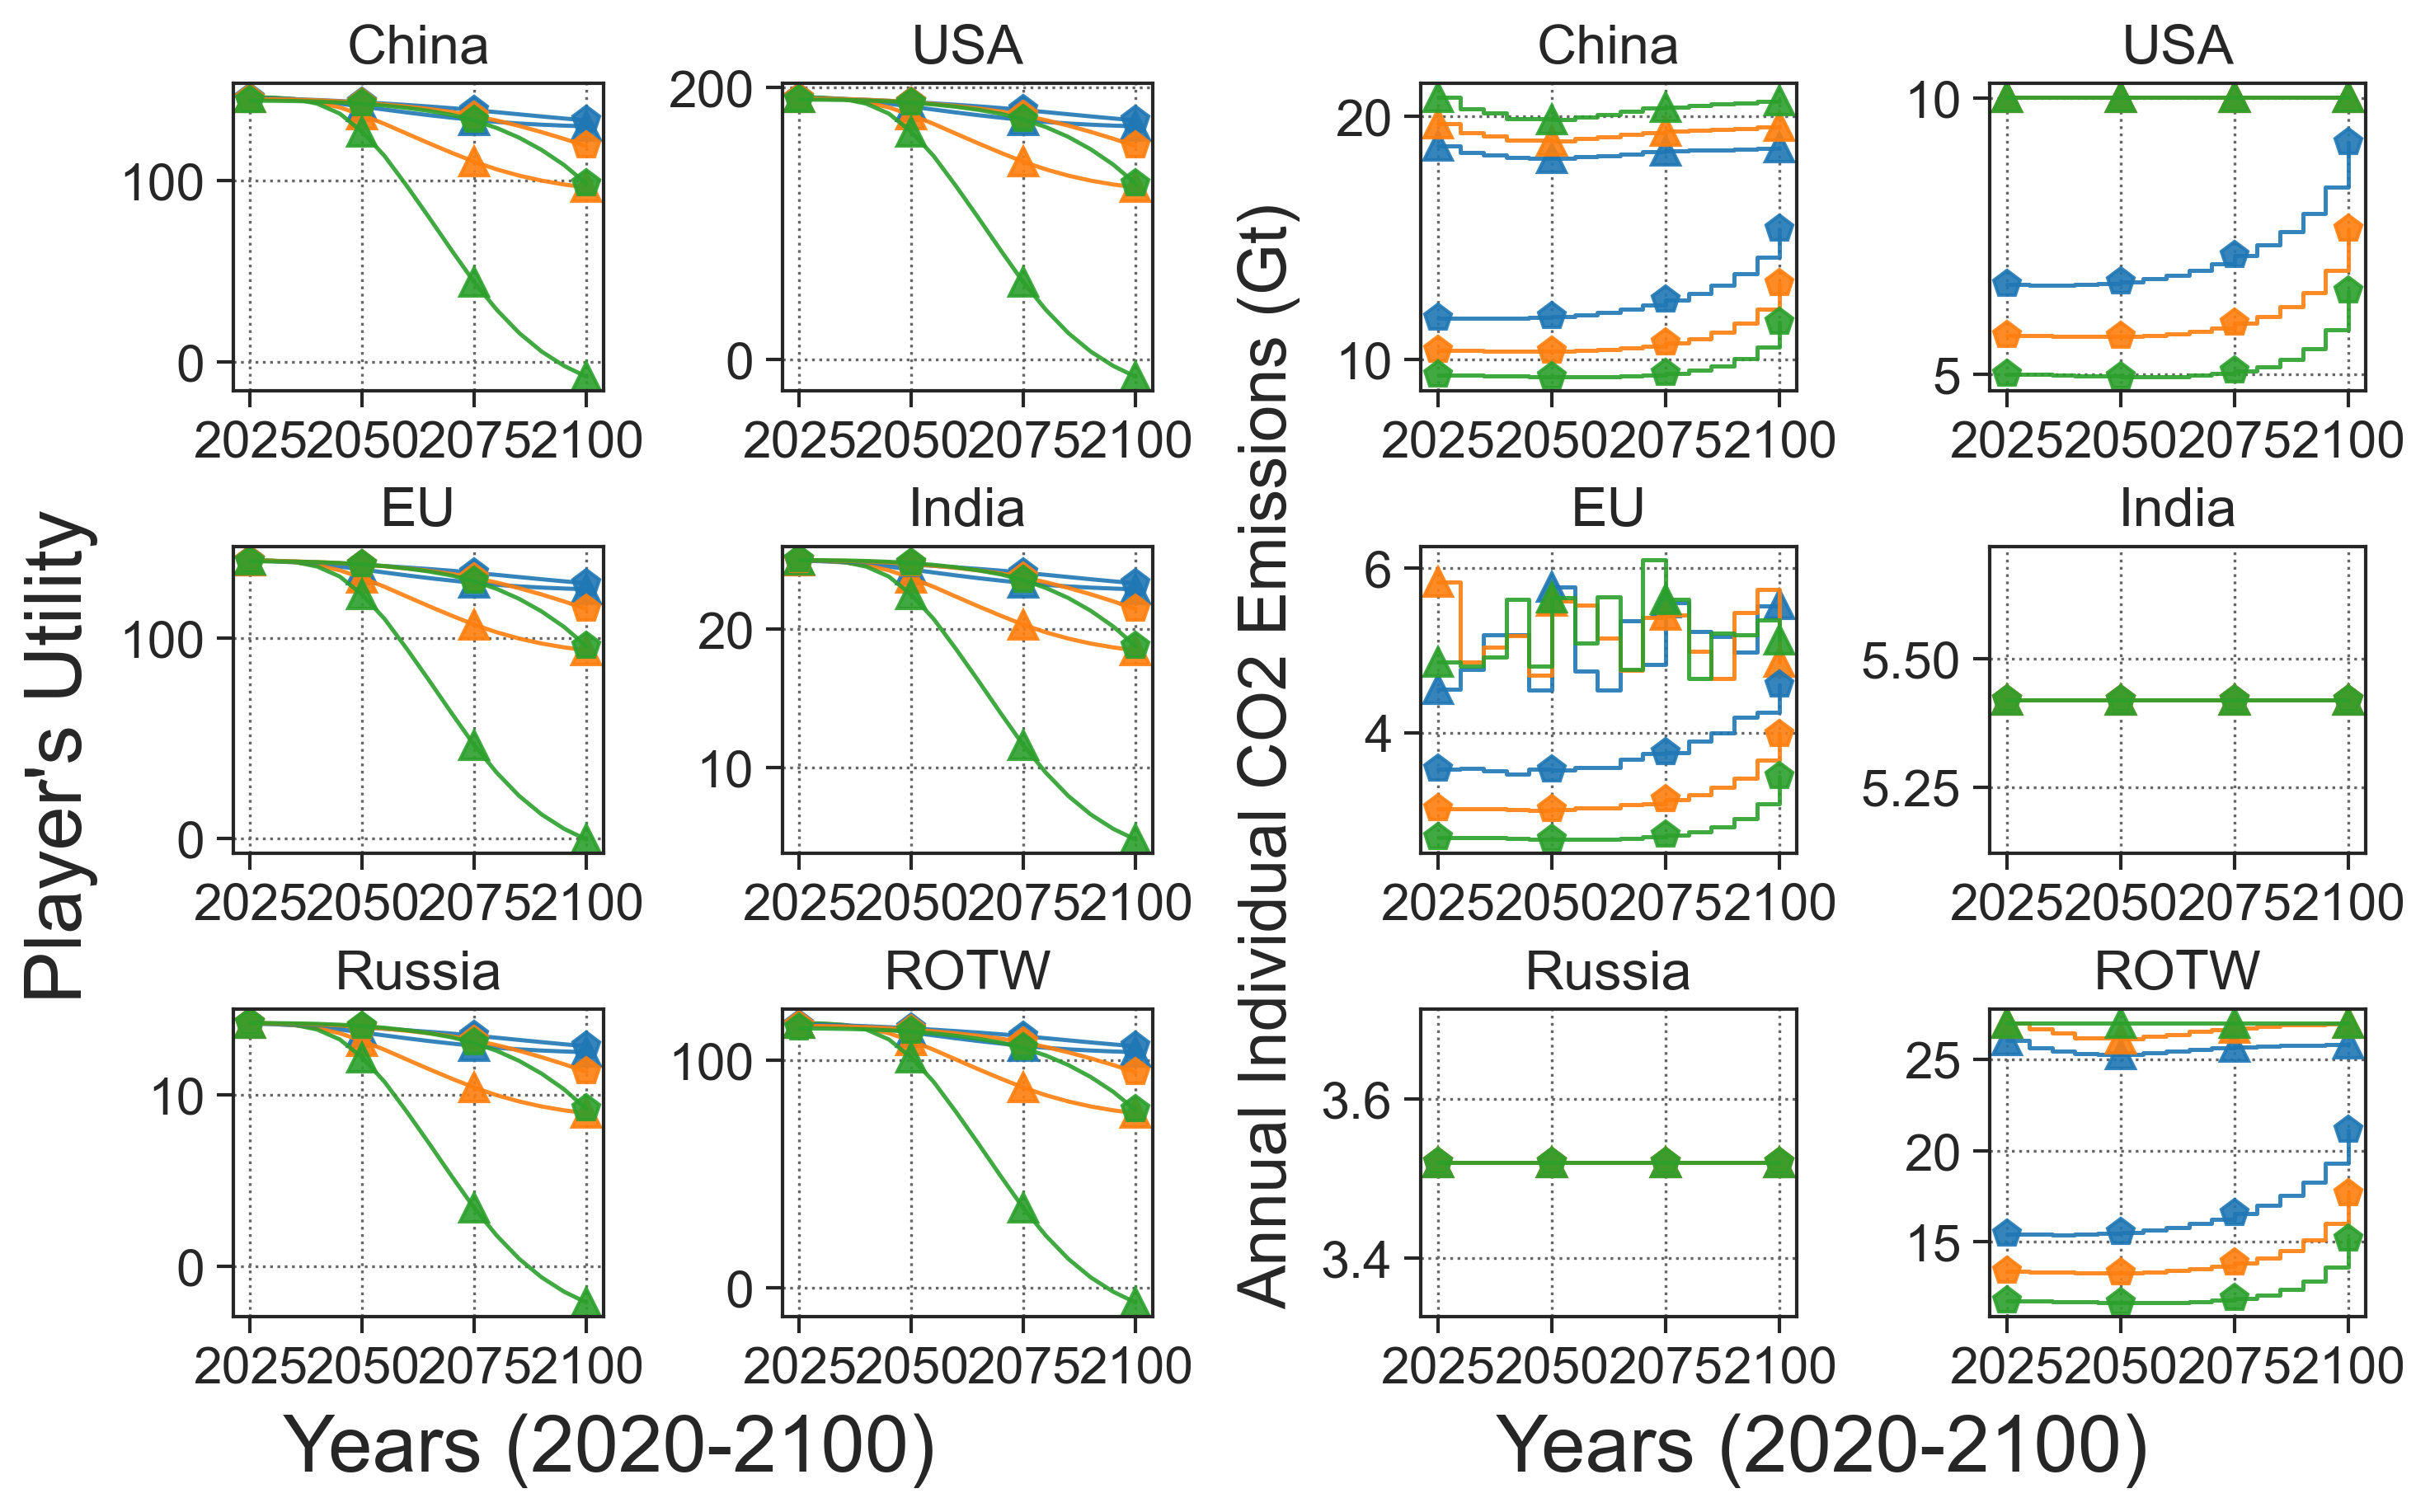

In [11]:

plots(classic, 'journal', list_label=list_label_classic, case = 'classic_sigmoid', X=X,  SO=False)